
=== Rolling Day 2025-01-02 ===
  train_cutoff=2024-08-01  val_cutoff=2024-12-31
  Forecast next 30 days from 2025-01-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2025-01-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2025-01-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2025-01-02_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2025-01-02_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2025-01-02_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2025-01-02_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2025-01-02_V1.pt
[sklearn] Loading SVM => ./best_SVM_2025-01-02_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2025-01-02_V1.pkl

=== Rolling Day 2025-01-03 ===
  train_cutoff=2024-08-02  val_cutoff=2025-01-01
  Forecast next 30 days from 2025-01-03 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2025-01-03_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2025-01-03_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2025-01-03_V1.pt
[PyTor

/tmp/ipykernel_469981/1682960974.py:380: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_469981/1682960974.py:399: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


===== JANUARY PERFORMANCE (mini-model approach) =====
 - Model=Boost, BaseDate=2025-01-02,   MAE_Jan=0.8661, baseAcc=0.862, slopeAlign=0.918, volAlign=0.636
 - Model=Boost, BaseDate=2025-01-03,   MAE_Jan=0.6489, baseAcc=0.897, slopeAlign=0.976, volAlign=0.558
 - Model=Boost, BaseDate=2025-01-04,   MAE_Jan=0.6465, baseAcc=0.897, slopeAlign=0.989, volAlign=0.464
 - Model=Boost, BaseDate=2025-01-05,   MAE_Jan=0.6896, baseAcc=0.890, slopeAlign=0.983, volAlign=0.453
 - Model=Boost, BaseDate=2025-01-06,   MAE_Jan=0.6232, baseAcc=0.901, slopeAlign=0.949, volAlign=0.589
 - Model=Boost, BaseDate=2025-01-07,   MAE_Jan=0.7299, baseAcc=0.884, slopeAlign=0.984, volAlign=0.508
 - Model=Boost, BaseDate=2025-01-08,   MAE_Jan=0.7690, baseAcc=0.877, slopeAlign=0.990, volAlign=0.460
 - Model=Boost, BaseDate=2025-01-09,   MAE_Jan=0.7392, baseAcc=0.882, slopeAlign=0.984, volAlign=0.481
 - Model=Boost, BaseDate=2025-01-10,   MAE_Jan=0.7217, baseAcc=0.885, slopeAlign=0.992, volAlign=0.457
 - Model=Boost, Bas

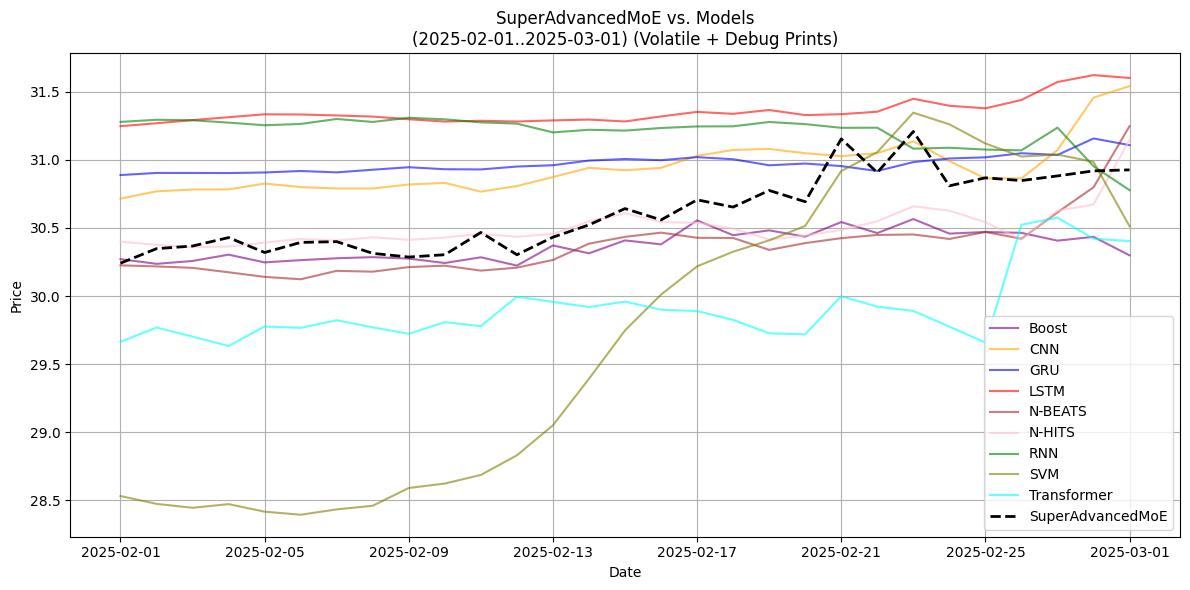


All done. This version prints debug info about each model's weighting, self consistency, january accuracy, etc!


In [1]:
####################################################
# SUPER ADVANCED MOE SCRIPT (Encouraging Volatility)
# WITH EXTRA PRINT STATEMENTS FOR REPORT
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from numpy.polynomial.polynomial import polyfit, polyval

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Global seeds & device
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

############################################
# 1) Model Definitions & Loading
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net= BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded= joblib.load(path)
    return SklearnWrapper(loaded)

############################################
# 2) Load & Scale Data
############################################
def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    # parse features
    for feat in features:
        if feat not in df_train.columns:
            df_train[feat]= np.nan
        else:
            df_train[feat]= df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat]= pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff= pd.to_datetime("2024-08-01")
    val_cutoff  = pd.to_datetime("2024-12-31")
    test_cutoff = pd.to_datetime("2025-01-01")

    df_trn= df_train[df_train["Date"]< train_cutoff].copy()
    df_val= df_train[(df_train["Date"]>= train_cutoff)&(df_train["Date"]<= val_cutoff)].copy()
    df_tst= df_train[df_train["Date"]>= test_cutoff].copy()

    df_trn_nonan= df_trn.dropna(subset=features)
    scaler= MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled= df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features]= scaler.transform(df_trn_nonan[features])
    df_val_scaled= df_val.copy()
    val_no_nan= df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features]= scaler.transform(val_no_nan[features])
    df_tst_scaled= df_tst.copy()
    trn_mins= df_trn_nonan[features].min()
    df_tst_filled= df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features]= scaler.transform(df_tst_filled)

    df_scaled= pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load complete
    df_complete= pd.read_csv(complete_csv)
    df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat]= df_complete[feat].astype(str).str.replace(",", "",regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3) Rolling Forecast with Mild Noise
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub)< window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Mild random noise => more "volatility".
    """
    def add_noise_4d(prices, std=0.005):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices + noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        # add mild noise
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=False
):
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        model_dict={}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file+= ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        daily_fcst={}
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt]= pd.DataFrame()

        # optional daily plots
        if do_daily_plots and (day_i== date_rng[-1]):
            # e.g. plot_daily_two_charts(...)
            pass

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 4) Build "mini-models" & Weighted MOE
############################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    start_jan= pd.to_datetime("2025-01-01")
    end_jan=   pd.to_datetime("2025-01-31")
    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"]= (df_merge["Pred_Price_unscaled"]- df_merge["ActualPrice"]).abs()

    # mae
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => polynomial
    def poly_slope_diff(sub):
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp
    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol<1e-9:
        real_vol= 0.01

    # predicted vol
    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_): vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align_func(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align_func)

    # merge
    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]],
                          on=["Model","BaseDate"], how="left")

    # mae => baseAcc
    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0- ((mini_models["mae_jan"]-mae_min)/(mae_max-mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===")
    print("We treat each (model, baseDate) as a distinct mini-model, measuring:")
    print(" - MAE in Jan => baseAcc")
    print(" - Polynomial slope alignment => slopeAlign_jan")
    print(" - Volatility alignment => volAlign_jan")
    print("Then we do daily 'population voting' for direction, mild random noise, etc.\n")

    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average.\n")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    # 1) Print each model's january metrics
    print("===== JANUARY PERFORMANCE (mini-model approach) =====")
    for idx,row in mini_models.iterrows():
        print(f" - Model={row['Model']}, BaseDate={row['BaseDate'].date()},"
              f"   MAE_Jan={row['mae_jan']:.4f}, baseAcc={row['baseAcc']:.3f},"
              f" slopeAlign={row['slopeAlign_jan']:.3f}, volAlign={row['volAlign_jan']:.3f}")

    print(f"\nRealVol (Jan) = {real_vol:.4f}\n")

    # build dictionary => {(model,baseDate): {baseAcc, slopeAlign_jan, volAlign_jan}}
    mm_dict={}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])]= {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2025-02-01")
    end_moe=   pd.to_datetime("2025-03-01")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")
    records=[]

    for d in all_days:
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        d_prev= d - pd.Timedelta(days=1)
        ups=0
        downs=0
        total=0

        w_sums=0.0
        weighted_price=0.0

        # We'll store all the row-level debug info in a list, then print after we compute MOE
        day_debug_info=[]

        for idx,row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            if (m,bD) not in mm_dict:
                # fallback => weight=0
                continue

            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA= mm_dict[(m,bD)]["volAlign_jan"]

            # direction factor
            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
                direction_str="(no prev data)"
            else:
                p_today= row["Pred_Price_unscaled"]
                p_yest= df_dprev["Pred_Price_unscaled"].values[0]
                if p_today> p_yest:
                    ups+=1
                    dirFactor=1.1
                    direction_str="UP"
                elif p_today< p_yest:
                    downs+=1
                    dirFactor=0.9
                    direction_str="DOWN"
                else:
                    dirFactor=1.0
                    direction_str="FLAT"
                total+=1

            w= baseAcc* slopeA* volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

            # store debug info
            day_debug_info.append({
                "Model": m,
                "BaseDate": bD.date(),
                "Pred_Price": row["Pred_Price_unscaled"],
                "baseAcc": baseAcc,
                "slopeA": slopeA,
                "volA": volA,
                "dirFactor": dirFactor,
                "Weight": w,
                "Direction": direction_str
            })

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
        else:
            fraction_up= 0.0
            fraction_down=0.0

        # population shift => if ups>70% => +1%; if downs>70% => -1%
        popShift= 1.0
        if fraction_up> 0.7:
            popShift=1.01
            day_moe*= 1.01
        elif fraction_down> 0.7:
            popShift=0.99
            day_moe*= 0.99

        # final mild random noise => encourage more "volatility"
        random_factor= np.random.normal(0, day_moe*0.002)
        day_moe+= random_factor

        # now we print the debug info for this day
        print(f"\n=== {d.date()} ===")
        print(f"  total mini-models with prev day info={total}, ups={ups}, downs={downs}, fraction_up={fraction_up:.2f}, fraction_down={fraction_down:.2f}")
        print(f"  population shift factor={popShift:.3f}, random noise={random_factor:.3f}")
        print(f"  WeightedSum={w_sums:.3f}, PreShiftedMOE={day_moe-random_factor:.3f}")

        print("  => DETAILED MODEL WEIGHTS =>")
        for dbg in day_debug_info:
            print(f"    * {dbg['Model']}, baseDate={dbg['BaseDate']}, Price={dbg['Pred_Price']:.2f},"
                  f" bAcc={dbg['baseAcc']:.3f}, slope={dbg['slopeA']:.3f}, vol={dbg['volA']:.3f},"
                  f" dirF={dbg['dirFactor']:.3f}, finalW={dbg['Weight']:.3f}, direction={dbg['Direction']}")

        print(f"  => FINAL MOE Price = {day_moe:.3f}")

        records.append({
            "ForecastDate": d,
            "MOE_Price": day_moe
        })

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                      from_d=pd.to_datetime("2025-02-01"),
                                      to_d=pd.to_datetime("2025-03-01")):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d], with no actual overlay.
    """
    df_sel= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= from_d)&
        (final_rolling_fcst["ForecastDate"]<= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }
    # plot each model => average line
    for m in df_sel["Model"].unique():
        df_m= df_sel[df_sel["Model"]== m].copy()
        df_m_agg= df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(m,"gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    # plot MoE
    df_moe_sub= df_moe[
        (df_moe["ForecastDate"]>= from_d)&
        (df_moe["ForecastDate"]<= to_d)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black",linestyle="--",lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile + Debug Prints)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler= load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-08-01"),
        start_val_cutoff=pd.to_datetime("2024-12-31"),
        start_pred=pd.to_datetime("2025-01-02"),
        end_pred=pd.to_datetime("2025-01-31"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(30))

    # 3) Build "super advanced" mixture-of-experts => with polynomials + mild final noise + debug prints
    df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)

    # 4) Plot => from 2025-02-01..2025-03-01
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-02-01"),
        to_d=pd.to_datetime("2025-03-01")
    )

    print("\nAll done. This version prints debug info about each model's weighting, self consistency, january accuracy, etc!")
